# Step 6: SHAP Analysis
Understand the impact of features on the XGBoost model using SHAP (SHapley Additive exPlanations) values.

SHAP values help us:
- Quantify how much each feature contributes to each prediction
- Understand global feature importance across the entire dataset
- Detect feature interactions and dependencies
- Make informed decisions about feature selection and engineering


In [ ]:
# Install SHAP library if not already installed
!pip install shap

# Import necessary libraries
import shap  # For model interpretability
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For visualization
from xgboost import XGBRegressor  # XGBoost model implementation

In [ ]:
# Load the feature-engineered training data
train = pd.read_csv("datasets/train_fe.csv")
# Separate features (X) from target variable (y)
X = train.drop(columns="Calories")
y = train["Calories"]

# Retrain the best XGBoost model from our hyperparameter tuning step
# These parameters were determined in xgboost_tuning_step4.ipynb
xgb = XGBRegressor(
    n_estimators=761,        # Number of gradient boosted trees
    max_depth=8,            # Maximum tree depth for base learners
    learning_rate=0.0433,   # Boosting learning rate
    subsample=0.8292,       # Subsample ratio of the training instances
    colsample_bytree=0.6293,# Subsample ratio of columns when constructing each tree
    gamma=0.0251,           # Minimum loss reduction required for further partition
    reg_alpha=0.8449,       # L1 regularization term on weights
    reg_lambda=2.7842,      # L2 regularization term on weights
    random_state=42,        # Random seed for reproducibility
    n_jobs=-1               # Use all available cores
)

# Train the model on our feature-engineered dataset
xgb.fit(X, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6293, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.0251, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.0433, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=761,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
# Create a SHAP explainer object for our trained XGBoost model
# This will be used to calculate SHAP values for feature importance analysis
explainer = shap.Explainer(xgb)

# Calculate SHAP values for all instances in our feature matrix
# This computes how much each feature contributes to each prediction
shap_values = explainer(X)

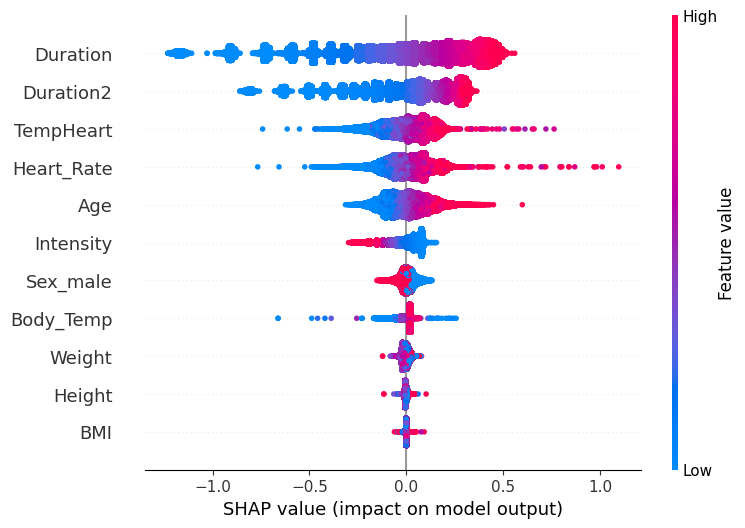

In [ ]:
# Generate a SHAP beeswarm plot
# This visualization shows the distribution of SHAP values for each feature
# - Features are ordered by importance (top = most important)
# - Each point represents one instance from the dataset
# - Colors indicate the feature value (red = high, blue = low)
# - Position on x-axis shows the SHAP value (impact on prediction)
shap.plots.beeswarm(shap_values, max_display=20)  # Show top 20 features

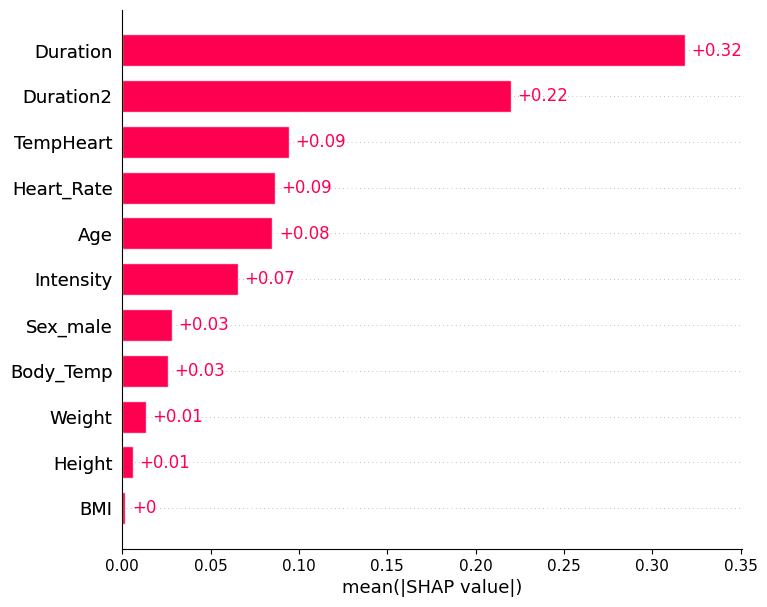

In [ ]:
# Generate a SHAP bar plot
# This shows the average magnitude of SHAP values (absolute impact) for each feature
# - Longer bars indicate features with greater overall impact on predictions
# - This is a measure of global feature importance across the entire dataset
shap.plots.bar(shap_values, max_display=20)  # Show top 20 features

### ❌ Weak Features (Low SHAP Value):

Based on our SHAP analysis, these features contribute minimally to calorie prediction:

| Feature     | Action                                                |
| ----------- | ----------------------------------------------------- |
| `BMI`       | **Drop it** — nearly 0 impact despite sounding useful |
| `Height`    | Consider dropping unless paired with `TempHeart`      |
| `Weight`    | Low on its own — try `Weight / Age` instead           |
| `Body_Temp` | Borderline — only keep if used in combination         |

These findings suggest we should focus our feature engineering efforts elsewhere or create interaction features that might better capture relationships between these variables.


### Top Impactful Features:

Our SHAP analysis revealed these features as the most influential for calorie expenditure prediction:

| Feature      | Mean SHAP | Impact Summary                                      |
| ------------ | --------- | --------------------------------------------------- |
| `Duration`   | **0.32**  | Strongest driver (longer duration = more calories)  |
| `Duration2`  | 0.22      | Reinforces nonlinear contribution — worth keeping   |
| `TempHeart`  | 0.09      | High impact — nonlinear, worth engineering with     |
| `Heart_Rate` | 0.09      | Add interactions                                    |
| `Age`        | 0.08      | Some influence — potential for `Duration/Age` ratio |
| `Intensity`  | 0.07      | Reinforce with `HeartRate/Intensity`, etc.          |

These findings validate our feature engineering approach, particularly the creation of `Duration2` and interaction features. Future modeling iterations should prioritize these high-impact variables and explore additional transformations or interactions among them.
